In [1]:
import numpy as np
import pandas as pd
import os
import csv
import ast
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import wquantiles

from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.examples.utils_example import (
    wavg,
    collapse,
    dataframe_by_group,
    graph_builder_bar,
    df_weighted_average_grouped)
from openfisca_france_indirect_taxation.build_survey_data.utils import weighted_sum
from openfisca_france_indirect_taxation.almost_ideal_demand_system.utils import add_niveau_vie_decile
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.calibration import get_inflators_by_year_energy
from openfisca_france_indirect_taxation.utils import assets_directory, get_input_data_frame
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import weighted_quantiles

In [2]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.new_calage_bdf_cn import (
    new_get_bdf_aggregates,
    new_get_cn_aggregates,
    new_get_inflators_bdf_to_cn,
    new_get_inflators_cn_to_cn,
    new_get_inflators,
    new_get_inflators_by_year)

In [3]:

simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
 'niveau_de_vie',
 'niveau_vie_decile',
 'rev_disponible',
 'pondmen',
 'situapr',
 'situacj',
 'nactifs',
 'npers']

In [4]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Reform_TVA_budget_2025 import augmente_tous_les_taux

In [5]:
year = 2024
data_year = 2017
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

In [6]:
survey_scenario = SurveyScenario.create(
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    data_year = data_year
    )

In [7]:
baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = True, period = 2024)['menage']
reform_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', period = 2024)['menage']

In [8]:
difference_menage = pd.DataFrame()
for taux in ['plein','intermediaire', 'reduit', 'super_reduit']:
    difference_menage['depenses_tva_taux_{}'.format(taux)] = reform_menage['depenses_tva_taux_{}'.format(taux)] - baseline_menage['depenses_tva_taux_{}'.format(taux)]
difference_menage[['rev_disponible','niveau_de_vie','niveau_vie_decile','pondmen','situapr','situacj','nactifs','npers']] = baseline_menage[['rev_disponible','niveau_de_vie','niveau_vie_decile','pondmen','situapr','situacj','nactifs','npers']]
difference_menage['actifs'] = difference_menage['nactifs'] > 0

In [9]:
difference_menage['cinquantieme_niveau_vie'] = weighted_quantiles(difference_menage['niveau_de_vie'], labels = np.arange(1,51), weights = difference_menage['pondmen'], return_quantiles=False)

In [10]:
perc_2 = difference_menage.loc[difference_menage['cinquantieme_niveau_vie'] == 1, :]
list_var = perc_2.columns.tolist()
list_var.remove('pondmen')
average_perc_2 = df_weighted_average_grouped(perc_2,'actifs',list_var)
average_perc_2['pondmen'] = perc_2.groupby(by = 'actifs')['pondmen'].sum()
average_perc_2['npers']=average_perc_2['npers'].round()
average_perc_2['actifs'] = average_perc_2['actifs'].astype('bool')

difference_menage = difference_menage.loc[difference_menage['cinquantieme_niveau_vie'] > 1] 
difference_menage = pd.concat([difference_menage,average_perc_2])
difference_menage = difference_menage.reset_index().drop('index', axis = 1) 

In [12]:
difference_indiv = difference_menage.loc[difference_menage.index.repeat(difference_menage['npers'])]
difference_indiv['quantile_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,11), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['quantile_indiv_niveau_vie'] = difference_indiv['quantile_indiv_niveau_vie'].astype(int)

In [13]:
difference_menage['npers'].sum(), len(difference_indiv)

(28122.0, 28122)

In [15]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
for taux in liste_taux:
   difference_indiv['Taux_effort_tva_taux_{}'.format(taux)] = difference_indiv['depenses_tva_taux_{}'.format(taux)] / difference_indiv['niveau_de_vie'] * 100
   
difference_by_decile = df_weighted_average_grouped(dataframe = difference_indiv, groupe = 'quantile_indiv_niveau_vie', varlist = ['depenses_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']]+
                                                   ['Taux_effort_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']])


In [ ]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import stacked_bar_plot

In [21]:
output_path = "C:/Users/veve1/OneDrive/Documents/IPP/Budget 2026 TVA/Figures/"

def stacked_bar_plot(df, variables, labels, title="Graphique à barres empilées", xlabel="Catégories", ylabel="Valeurs", colors = None, note = "Note",savefig = False, outfile = None):
    """
    Crée un bar plot empilé à partir des variables sélectionnées dans un DataFrame.

    :param df: DataFrame contenant les données
    :param variables: Liste des colonnes à empiler
    :param labels: Liste des labels pour chaque colonne
    :param title: Titre du graphique
    :param xlabel: Nom de l'axe des abscisses
    :param ylabel: Nom de l'axe des ordonnées
    """

    # Vérification que les listes sont cohérentes
    if len(variables) != len(labels):
        raise ValueError("Le nombre de variables et de labels doit être identique.")

    if colors and len(colors) < len(variables):
        raise ValueError("Le nombre de couleurs doit être supérieur au nombre de variables.")
    # Création de la figure et des axes
    fig, ax =  plt.subplots(figsize=(10, 7.5))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Indices des catégories (suppose que l'index est utilisé pour l'axe des x)
    x = np.arange(len(df))

    # Initialisation de la base pour l'empilement
    bottom = np.zeros(len(df))

    # Création des barres empilées
    for i, (var, label) in enumerate(zip(variables, labels)):
        color = colors[i] if colors else None
        ax.bar(x, df[var], label=label, bottom=bottom, color = color)
        bottom +=df[var].values

    # Ajout des légendes et titres
    ax.set_xlabel(xlabel, fontdict= {'fontsize' : 15}, fontweight ='bold')
    ax.set_ylabel(ylabel,  fontdict= {'fontsize' : 15}, fontweight ='bold')
    ax.set_title(title, fontdict= {'fontsize' : 17}, loc = 'left', fontweight ='bold')
    ax.tick_params(axis='y', labelsize=13)
    #ax.set_yticks(np.arange(0.1,1.1,0.1))
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, fontsize = 13)
    ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.1), ncol = 3, fontsize = 13)
    
    plt.xticks()
    if savefig and outfile:
            plt.savefig(os.path.join(output_path,outfile), bbox_inches = 'tight')
    plt.show()

In [17]:
difference_by_decile['depenses_tva_totales'] = difference_by_decile[['depenses_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']]].sum(axis = 1)

In [18]:
difference_by_decile

,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,depenses_tva_totales
quantile_indiv_niveau_vie,,,,,,,,,
1,118.530023,31.543739,72.739021,2.660687,0.958749,0.280628,0.582754,0.021574,225.473469
2,142.525717,32.378264,80.388305,4.174858,0.717256,0.163138,0.403129,0.021075,259.467144
3,147.047176,38.069156,80.887133,3.639131,0.611372,0.157526,0.335925,0.015073,269.642596
4,173.635372,46.691480,94.381714,4.490855,0.626192,0.169131,0.340413,0.016283,319.199420
5,185.325720,55.883245,96.382009,5.883547,0.591876,0.179431,0.308356,0.018762,343.474521
6,199.712881,93.242462,109.273937,5.969289,0.571917,0.267210,0.312812,0.017067,408.198570
7,210.437785,65.741719,112.597327,5.511718,0.539821,0.168845,0.288905,0.014145,394.288549
8,236.062983,82.788743,130.981799,6.738011,0.534730,0.189081,0.296488,0.015295,456.571536
9,256.819376,94.506643,140.146429,8.929189,0.492187,0.179256,0.268630,0.017110,500.401637


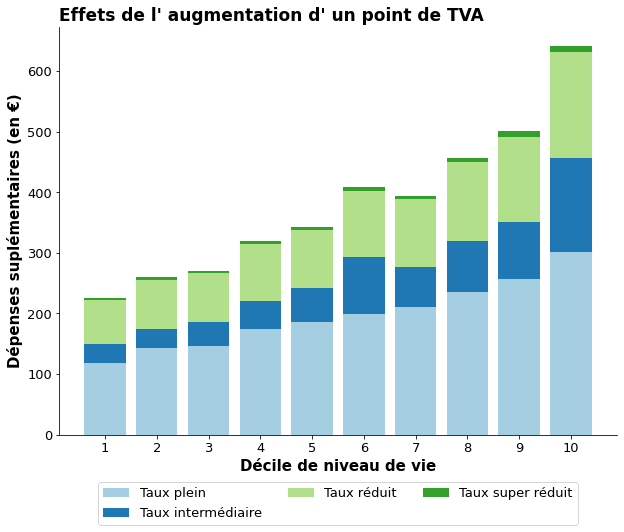

In [22]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['depenses_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Dépenses suplémentaires (en €)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Effet_net_augmentation_TVA.pdf')

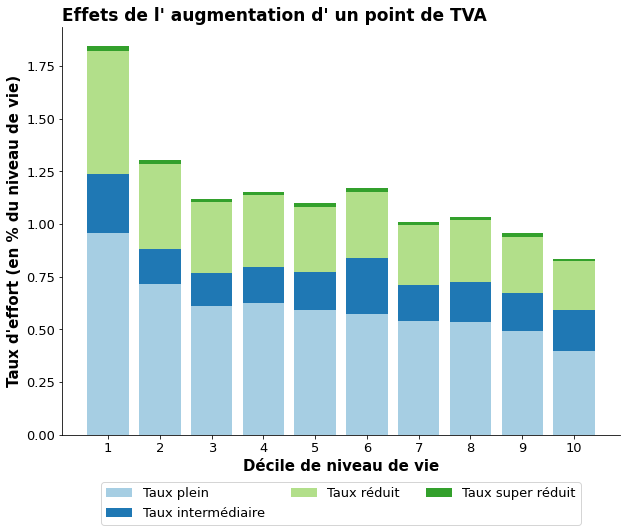

In [ ]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Taux d\'effort (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort.pdf')

In [ ]:
difference_by_decile_actifs_only = df_weighted_average_grouped(dataframe = difference_indiv[difference_indiv['actifs'] == True], groupe = 'quantile_indiv_niveau_vie', varlist = ['depenses_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']]+
                            ['Taux_effort_tva_taux_{}'.format(taux) for taux in ['plein','intermediaire', 'reduit', 'super_reduit']])


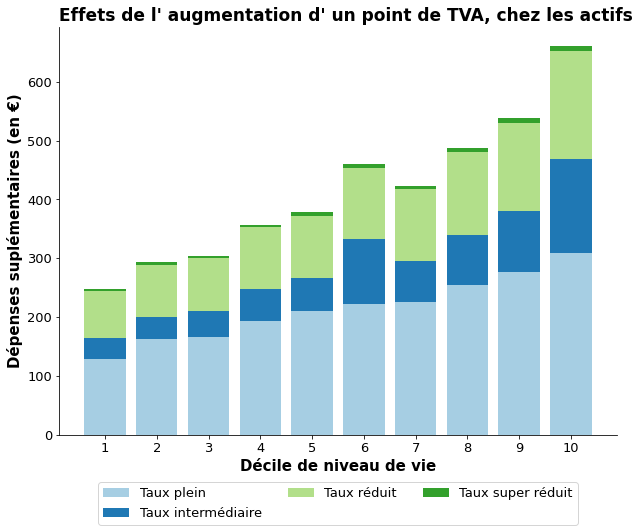

In [ ]:
stacked_bar_plot(difference_by_decile_actifs_only, 
                 variables = ['depenses_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA, chez les actifs',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Dépenses suplémentaires (en €)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Effet_net_augmentation_TVA_actifs_only.pdf')

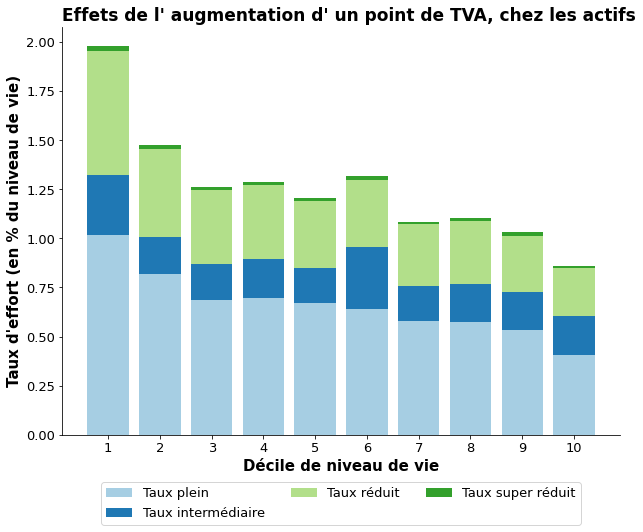

In [ ]:
stacked_bar_plot(difference_by_decile_actifs_only, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = 'Effets de l\' augmentation d\' un point de TVA, chez les actifs',
                 xlabel = 'Décile de niveau de vie' ,
                 ylabel ='Taux d\'effort (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_actifs_only.pdf')